# Extrinsics Calibration

In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np

from typing import List

import matplotlib.pyplot as plt

from dt_computer_vision.camera import CameraModel, Pixel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_corners
from dt_computer_vision.camera.calibration.extrinsics.ransac import estimate_homography

In [2]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, f"image1.jpg")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]]
}
camera = CameraModel(**camera_properties)

assert image.shape == (480, 640, 3)

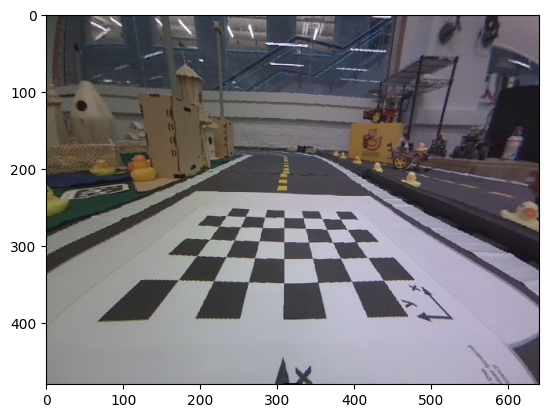

In [3]:
# rectify image
image = camera.rectifier.rectify(image)
rectified = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rectified)

In [4]:
# find corners
corners: List[Pixel] = find_corners(image, board)
print(f"Found {len(corners)} corners.")
assert len(corners) == (board.columns - 1) * (board.rows - 1)

Found 35 corners.


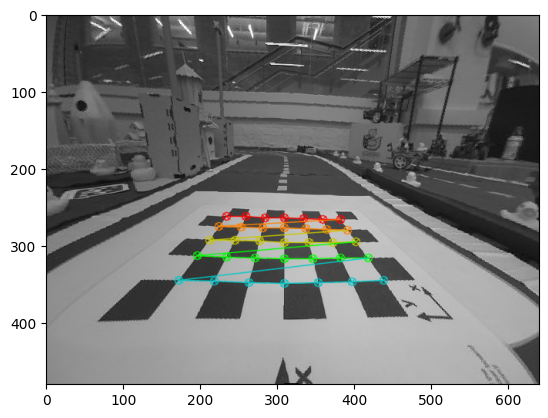

In [5]:
# draw detected corners on top of the image
image_w_corners = draw_corners(image, board, corners)
image_w_corners_rgb = cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_corners_rgb)

In [6]:
# estimate homography
H = estimate_homography(corners, board, camera)

In [7]:
# project the principal point onto the plane
ground_pp = np.dot(H, [0, 0, 1])
ground_pp = (ground_pp / ground_pp[2])[:2]
# manually measured when the image above was taken
expected_pp = [0.4, 0]

# compute error estimate
pp_error = np.linalg.norm(ground_pp - expected_pp)
print(f"Error is ~{pp_error * 100:.2f}cm.")

# make sure the error is within 3cm
assert pp_error <= 0.03

Error is ~2.03cm.


In [8]:
print(H)

[[-3.25205447e-02  1.19331664e-01  3.93352735e-01]
 [-4.72717010e-01 -9.44920613e-05 -1.91892118e-02]
 [-1.92169544e-01  3.63163818e+00  1.00000000e+00]]


# Ground Reprojection

In [9]:
from typing import List
from dt_computer_vision.camera.calibration.extrinsics.chessboard import get_ground_corners_and_error, compute_placement_error

from dt_computer_vision.camera import NormalizedImagePoint
from dt_computer_vision.ground_projection import GroundPoint

image_corners: List[NormalizedImagePoint]
ground_corners: List[GroundPoint]
ground_corners_projected: List[GroundPoint]
errors: List[float]

image_corners, ground_corners, ground_corners_projected, errors = get_ground_corners_and_error(camera, corners, board, H)

for i, (image_corner, ground_corner, ground_corner_projected, error) in enumerate(zip(image_corners, ground_corners, ground_corners_projected, errors)):
    # print out (image point, ground computed, and ground oracle) points
    print(f"{i}\t: I[{image_corner}] -> Gc[{ground_corner_projected}] ~ G[{ground_corner}]: {float(error):.4f}m")

# compute average error
avg_error = np.average(errors)
std_error = np.std(errors)
print(f"Overall error: {avg_error:.4f}m +/- {std_error:.4f}m")

# find all corners that are on the X and Y axis of the calibration pattern (the lines partitioning the board into 4 equal quadrants)
placement_error: float = compute_placement_error(corners, board, errors)
print(f"Placement error: {placement_error:.4f}m")

0	: I[P(-0.2947, 0.0665)] -> Gc[P(0.3165, 0.0925)] ~ G[P(0.315, 0.093)]: 0.0016m
1	: I[P(-0.2099, 0.0693)] -> Gc[P(0.3162, 0.0619)] ~ G[P(0.315, 0.062)]: 0.0012m
2	: I[P(-0.1264, 0.0727)] -> Gc[P(0.3152, 0.0315)] ~ G[P(0.315, 0.031)]: 0.0005m
3	: I[P(-0.0415, 0.0746)] -> Gc[P(0.3156, 0.0003)] ~ G[P(0.315, 0.0)]: 0.0007m
4	: I[P(0.0443, 0.0761)] -> Gc[P(0.3162, -0.0317)] ~ G[P(0.315, -0.031)]: 0.0014m
5	: I[P(0.1263, 0.0798)] -> Gc[P(0.3151, -0.0623)] ~ G[P(0.315, -0.062)]: 0.0003m
6	: I[P(0.2053, 0.0813)] -> Gc[P(0.3157, -0.0926)] ~ G[P(0.315, -0.093)]: 0.0008m
7	: I[P(-0.3274, 0.1103)] -> Gc[P(0.285, 0.0926)] ~ G[P(0.284, 0.093)]: 0.0011m
8	: I[P(-0.2305, 0.1154)] -> Gc[P(0.2833, 0.0614)] ~ G[P(0.284, 0.062)]: 0.0009m
9	: I[P(-0.1352, 0.1179)] -> Gc[P(0.2832, 0.0308)] ~ G[P(0.284, 0.031)]: 0.0008m
10	: I[P(-0.0417, 0.1192)] -> Gc[P(0.2838, 0.0004)] ~ G[P(0.284, 0.0)]: 0.0004m
11	: I[P(0.0517, 0.1223)] -> Gc[P(0.2833, -0.0304)] ~ G[P(0.284, -0.031)]: 0.0009m
12	: I[P(0.1458, 0.1259)] -

# GUI

In [10]:
from matplotlib.pyplot import figure

from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_gui, top_view_projected_corners
from dt_computer_vision.ground_projection.rendering import draw_grid_image

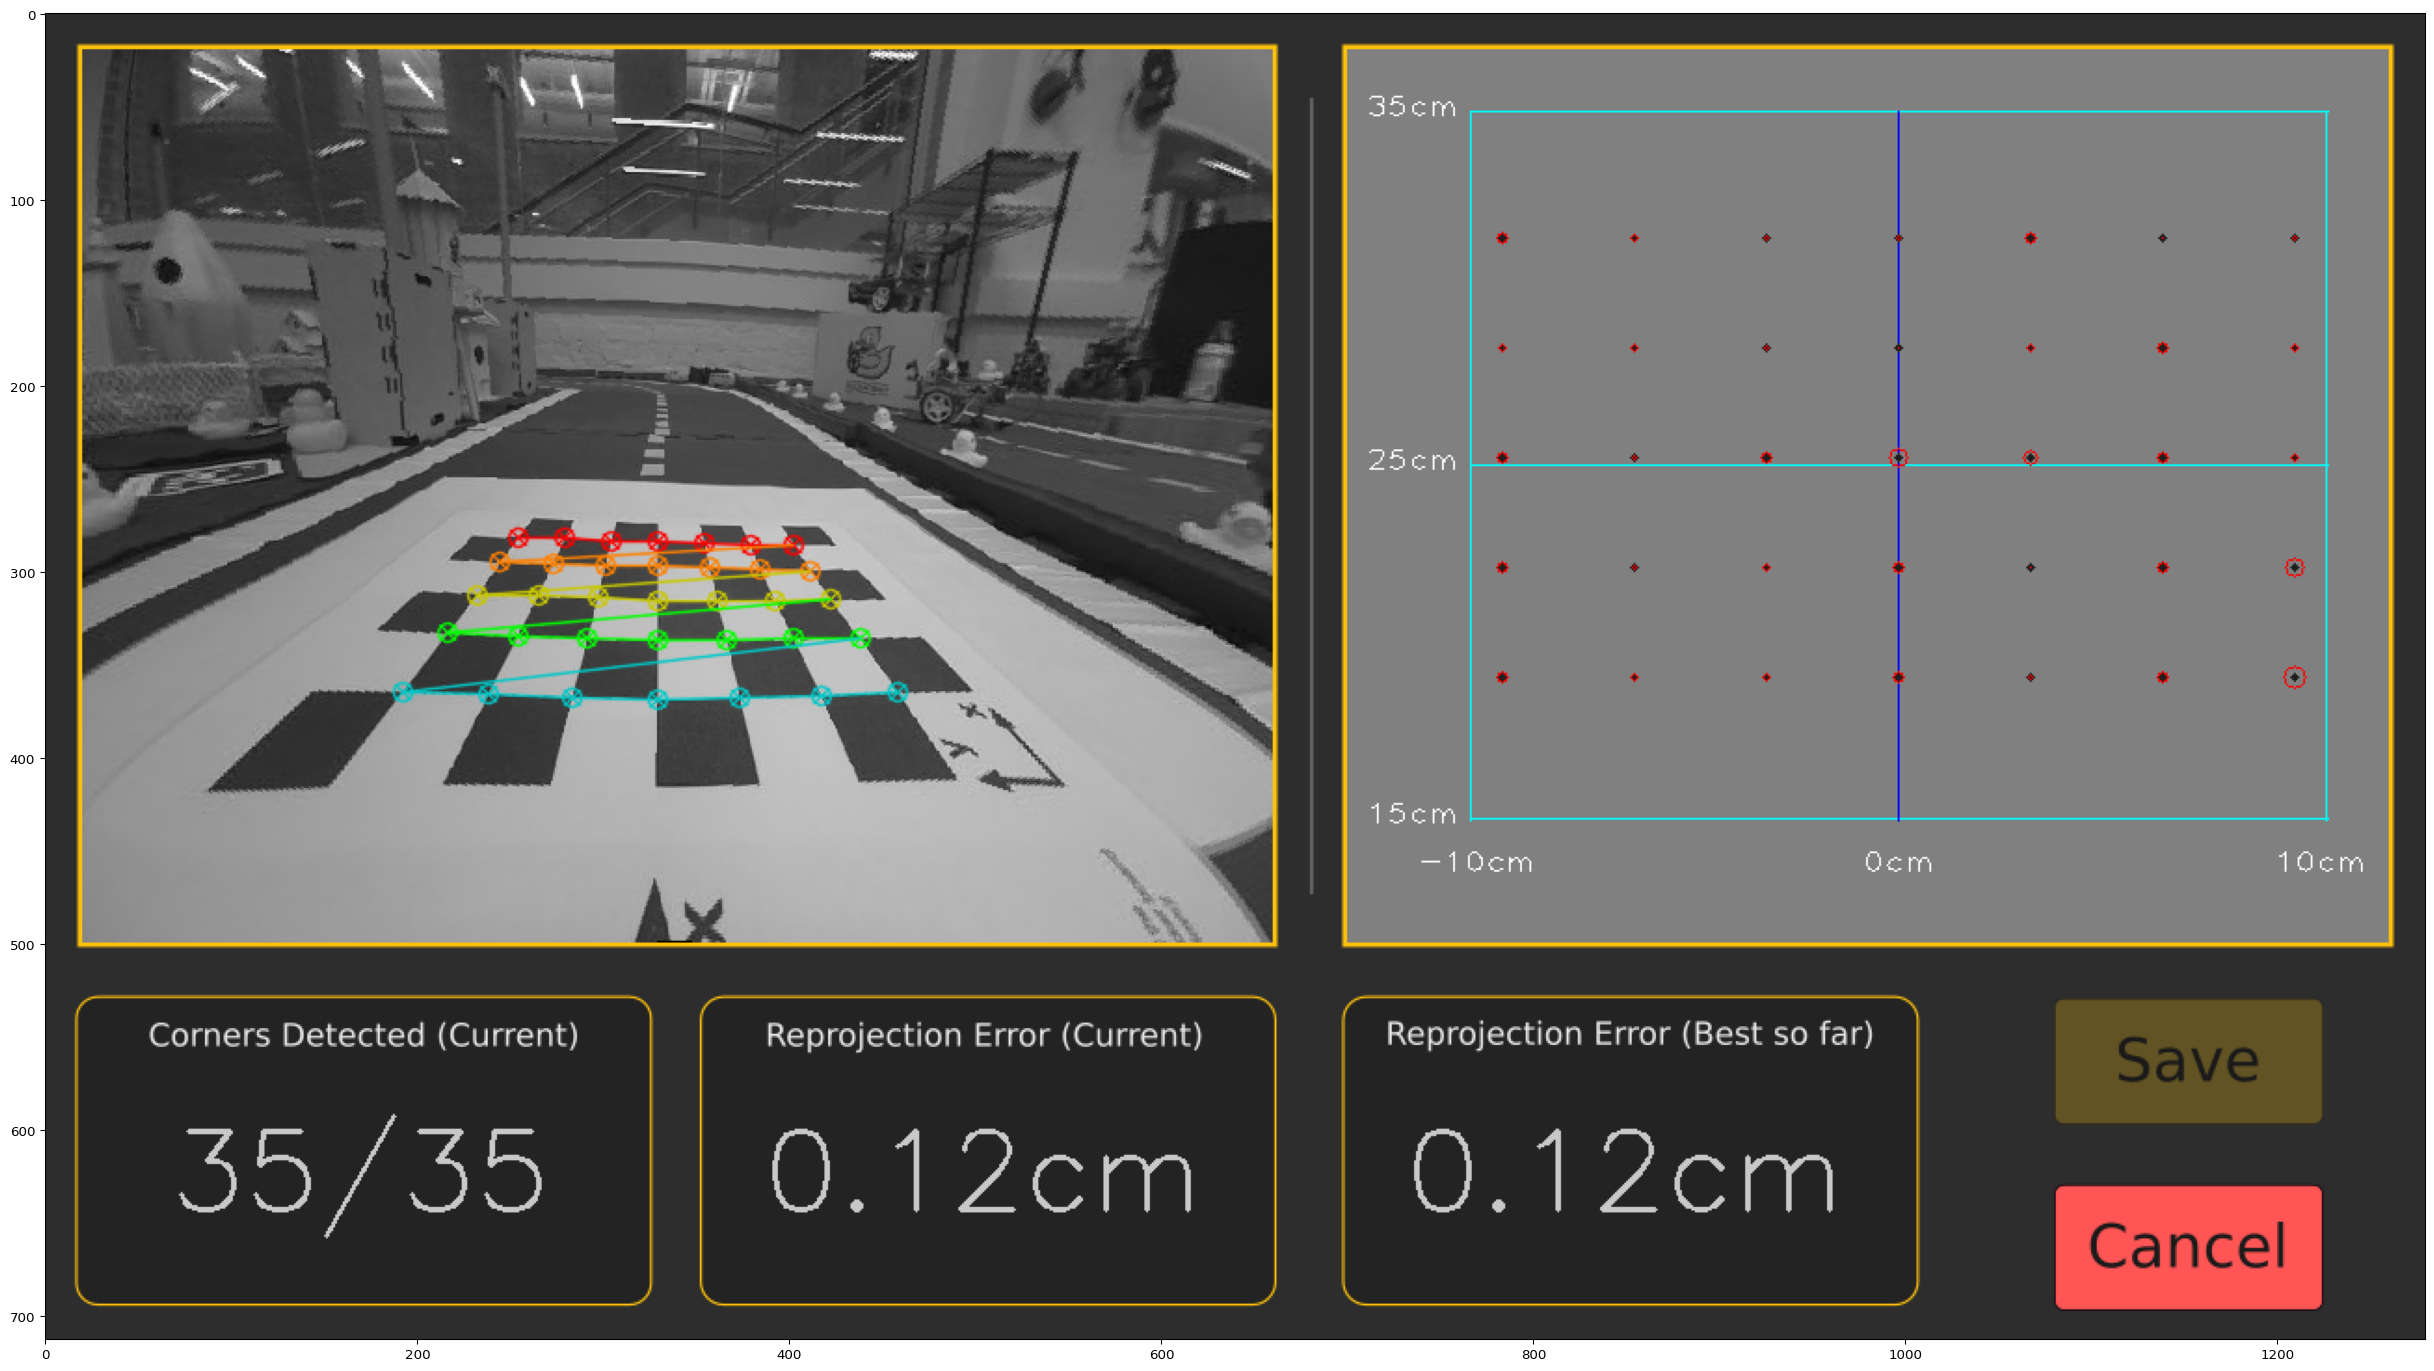

In [11]:
fig = figure(figsize=(32, 18), dpi=96)

right = top_view_projected_corners(
    ground_corners,
    errors,
    (560, 480),
    start_y=0.15,
)

gui = draw_gui(False, image_w_corners, right, len(corners), board, avg_error, avg_error)

gui = cv2.cvtColor(gui, cv2.COLOR_BGR2RGB)
plt.imshow(gui)